<a href="https://www.kaggle.com/code/rahultheogre/rsna-pneumonia-detection-eda?scriptVersionId=111590005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Exploratory Data Analysis of RSNA Pneumonia Dataset

#### Data fields
- patientId - A patientId. Each patientId corresponds to a unique image.
- x - the upper-left x coordinate of the bounding box.
- y - the upper-left y coordinate of the bounding box.
- width - the width of the bounding box.
- height - the height of the bounding box.
- Target - the binary Target, indicating whether this sample has evidence of pneumonia.

In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
import seaborn as sns
sns.set(style='whitegrid') #set seaborn plotting aesthetics
%matplotlib inline

import os
import csv
from pathlib import Path
import pydicom
from glob import glob
from matplotlib.patches import Rectangle

In [2]:
# Reading the data

train_labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
train_class = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

train_path = os.listdir(Path('../input/rsna-pneumonia-detection-challenge/stage_2_train_images'))
test_path = os.listdir(Path('../input/rsna-pneumonia-detection-challenge/stage_2_test_images'))

print('Number of Duplicated records in train_labels file:', train_labels.duplicated().sum())
print('------------------------------------------------------------------------')
print(train_labels.info())
print('------------------------------------------------------------------------')
print(train_labels.head(15))

Number of Duplicated records in train_labels file: 0
------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None
------------------------------------------------------------------------
                               patientId      x      y  width  height  Target
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2   00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   

- Each record in the train_labels table contains 
  1. a patientId (one unique value per patient)
  2. corresponding abnormality bounding box defined by the upper-left hand corner (x, y) coordinate 
  3. a target (either 0 or 1 for absence or presence of pneumonia, respectively) 
- There are many NaN values in four columns. But they seem to follow a trend. 
  - For each record in which we have any of value in the tuple (x,y,width,height) as NeN, the other 3 will also be NaN.
   - This seems plausible. x and y are values of a tuple. Together they stand for a location, and width and height also form a pair. All four, together, define the bound of the abnormality in on the lung, called as opacity. 
   - All will be NaN together, or none will.
  - If the values in the tuple (x,y,width,height) is NaN, then the value in the column 'Target' is definitely 0, that is, the patient is not pneumonic.
   - Target, as per data dictionary, stands for whether the patient is pneuomonic or not. And in this study, we are looking for  the same through an analysis of images. 

In [3]:
print("Confirming the connection between pnuemonia and presence of 'abrnomality' on the lung. The number of unique Target values when the feature has value NaN:", len(train_labels[train_labels.x.isna()]['Target'].unique()))

Confirming the connection between pnuemonia and presence of 'abrnomality' on the lung. The number of unique Target values when the feature has value NaN: 1


- Number of unqiue values turn out to be 1, which imply all patients for whom the record shows absence of 'abnormality', will be non-pneumonic.
- Continuing, thus the missing values in the dataset have a reason. There are empty non-existent values conditioned on Target being 1 or zero. In other words, the Target column is dependent on the tuple of these four features. We don't need it. We won't remove it though. This is out prediction variable. Instead, we will match the values in this table withe images and perform out analysis. 
- Let's check if the dataset has duplicate values. And drop them if there are.

In [5]:
print('Number of Duplicated records in train_labels file:', train_class.duplicated().sum())
print('------------------------------------------------------------------------')
print('Dropping duplicate records from train_class')
train_class.drop_duplicates(inplace = True)
print('Checking the number of Duplicated records in train_class file:', train_class.duplicated().sum())

print('------------------------------------------------------------')
print('Understanding the train_class file')
print(train_class.info())
print('------------------------------------------------------------------------')
print(train_class.head(15))

Number of Duplicated records in train_labels file: 0
------------------------------------------------------------------------
Dropping duplicate records from train_class
Checking the number of Duplicated records in train_class file: 0
------------------------------------------------------------
Understanding the train_class file
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
dtypes: object(2)
memory usage: 625.4+ KB
None
------------------------------------------------------------------------
                               patientId                         class
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2   00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3

- Each record in the train_class table contains
    1. a patientId
    2. a class 
- There are no missing values, as is clear from the info() table.
- From the same table,  it's clear that the number of records in the two tables: train_class and train_labels is same: 30227

Number of unique patientId values in train_class:  26684
Number of unique patientId values in train_label:  26684
Distribution of the classes:


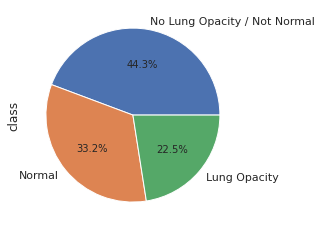

In [6]:
# checking for unique patientId values. 
print('Number of unique patientId values in train_class: ', train_class['patientId'].nunique())
print('Number of unique patientId values in train_label: ', train_labels.patientId.nunique())
print('Distribution of the classes:')
train_class['class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

Number of patientIds are same in both the train_labels dataset and train_class.

### Meaning of labels

Let's now understand what these labels mean.
- 'Normal' indicates that the lung x-ray is normal, and so is the lung. 
- 'Lung Opacity' confirms that the the lung has opacity and is indicative of pneumonia.
- 'No Lung Opacity / Not Normal' indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. 

The third label is going to be challenging. These images have some abnormality, but they are not pneumomic. Our machine learning algorithm should be able to read this into the images, and not get fooled. In other words, it should be able to correctly classify the abnormal images into 'with pnuemonia' and 'without pneumonia'.

Also, there's a relatively uniform split between the three classes, with nearly 2/3rd of the data comprising of no pneumonia (either completely normal or no lung opacity / not normal). Compared to most medical imaging datasets, where the prevalence of disease is quite low, this dataset has been significantly enriched with pathology.

Let's analyze the distribution of the Target values in train_labels. 

Distribution of Target values 
 0    20672
1     9555
Name: Target, dtype: int64


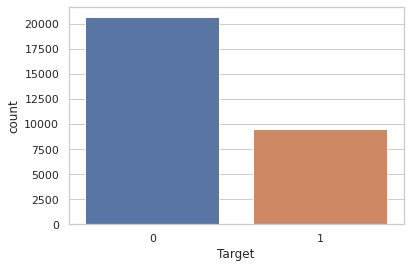

In [7]:
print('Distribution of Target values','\n',train_labels['Target'].value_counts())
sns.countplot(x=train_labels['Target'])
plt.show()

There are 9555 records with Target = 1 and same number of records with class = Lung Opacity. We don't need to analyze the data with code to know that they corressspond to the same patientId. If the x-ray of a patient has region(s) of lung opacity, then they are pneumonic.

### merging train_labels & train_class into train_meta

In [8]:
train_meta = pd.merge(train_labels, train_class)
print('Checking info and a few random samples of newly created train_meta to assert everything is alright:')
print(train_meta.info())
print(train_meta.sample(15))

Checking info and a few random samples of newly created train_meta to assert everything is alright:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB
None
                                  patientId      x      y  width  height  \
9402   670080d5-d370-4c5a-b617-f5409d52a88d    NaN    NaN    NaN     NaN   
2869   34a959dd-8f9e-4fe4-8451-65e93e59fe2f    NaN    NaN    NaN     NaN   
17112  a445b3e6-a5ab-4eda-93d8-7f26d4076748  606.0  189.0  321.0   715.0   
9963   6b78d3dc-4db6-4ab9-9e7b-2d91dff9c4c2    NaN    NaN    

A visual inspection confirms our ideas about 'Target' and 'class' and their relationship. Let us group the data according to them, and see if our assumptions were right with a bivariate countplot

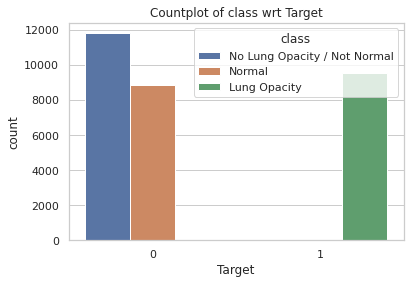

In [9]:
sns.countplot(x=train_meta['Target'], hue=train_meta['class'])
plt.title('Countplot of class wrt Target')
plt.show()

There is no incongruence. If class = Lung Opacity, then Target = 1. And if Target = 1, class is necessarily Lung Opacity. In other words, all the 'abnormalities' with class = No Lung Opacity/Not Normal come under the category of Target=0.

In [10]:
print('Number of images in train set is:', len(train_path))
print('Number of patients in csv file as per their Id is:', train_meta.patientId.nunique())
print('Number of images in test set is:', len(test_path))

Number of images in train set is: 26684
Number of patients in csv file as per their Id is: 26684
Number of images in test set is: 3000


So far we have been doing good. Their are no inconsistencies. Let us check the first image in the train set as per its index value in the corresponding meta table.

# DICOM

The size of the image is:  (1024, 1024) 

The pixel values of the image as a numpy array are:
 [[144 128 114 ... 176 184 117]
 [125 109  95 ... 171 178 111]
 [104  89  75 ... 166 175 108]
 ...
 [ 16  14  11 ...  19  15   3]
 [ 18  16  12 ...  21  17   5]
 [ 19  17  13 ...  23  19   6]] 

The image looks like:
 AxesImage(54,36;334.8x217.44)
The meta information saved in DICOM file is as follows:
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-----

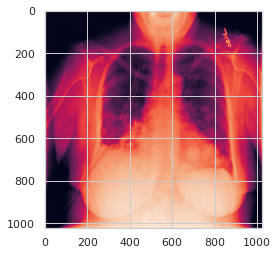

In [11]:
first_img = train_meta.patientId[0]
img1_file = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' %first_img
img1_meta = pydicom.read_file(img1_file)

img1_px = img1_meta.pixel_array
print('The size of the image is: ', img1_px.shape, '\n')
print('The pixel values of the image as a numpy array are:\n', img1_px, '\n')
print('The image looks like:\n', plt.imshow(img1_px))
print('The meta information saved in DICOM file is as follows:')
print(img1_meta)

Most of the standard headers containing patient identifable information have been anonymized (removed) so we are left with a relatively sparse set of metadata. The primary field we will be accessing is the underlying pixel data.

A few inferences that can be made from the above meta data contained in the dicom
- A lot of infomation from the dicom has been removed. For example, we don't have the patient's name which is the same as their id. Also, there is no physician name and study id, nor is there the DOB of the patient. 
 - There are 1024 rows and columns in the image- which should be the standard size of all the images. We will check. Else we will have to resize all the images in one size before feeding them in a Deep Neural Network.
 - It is monochrome i.e. grayscale. 
 - Every image takes up 8 bit of data.

## Bounding Boxes

In [15]:
print('Total records for class information values:', train_class.shape[0])
print('------------------------------------------------------------------------')
print('Total number of bounding boxes:', train_labels.shape[0])
print('------------------------------------------------------------------------')
box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')
train_meta = pd.merge(train_meta, box_df, on='patientId')

print('Distribution of number of boxes in the lungs of each patient:')
box_df = box_df.groupby('boxes').size().reset_index(name='patients')
box_df = pd.DataFrame(box_df)
print(box_df)

Total records for class information values: 26684
------------------------------------------------------------------------
Total number of bounding boxes: 30227
------------------------------------------------------------------------
Distribution of number of boxes in the lungs of each patient:
   boxes  patients
0      1     23286
1      2      3266
2      3       119
3      4        13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'boxes_x'} in the result is deprecated and will raise a MergeError in a future version.
  


# Visualizing Images with bounding boxes

In [18]:
train_meta.head()

,patientId,x,y,width,height,Target,class,boxes_x,boxes_y,boxes_x,boxes_y,PatientAge,PatientSex,ImagePath
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,1,1,1,51,F,../input/rsna-pneumonia-detection-challenge/st...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,1,1,1,48,F,../input/rsna-pneumonia-detection-challenge/st...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,1,1,1,19,M,../input/rsna-pneumonia-detection-challenge/st...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,1,1,1,1,28,M,../input/rsna-pneumonia-detection-challenge/st...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,2,2,2,32,F,../input/rsna-pneumonia-detection-challenge/st...


In [16]:
vars = ['PatientAge','PatientSex','ImagePath']

def process_dicom_data(df, path):
    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None
    images = os.listdir(path)
    #looping through each dicom image, extract the information from it, and 
    # add it to the DataFrame
    for i, img_name in enumerate(images):
        imagePath = os.path.join(path,img_name)
        img_data = pydicom.read_file(imagePath)
        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        df.loc[idx, 'ImagePath'] = str.format(imagePath)
        

print('Saving the parsed data as DataFrame for a neat visualization')
process_dicom_data(train_meta,'../input/rsna-pneumonia-detection-challenge/stage_2_train_images')

print('Now, we subset a sample from the training set DataFrame so we have one example of every type of image.')
print('We do this by successively grouping the training dataset by Target, class, and number of boxes')

Saving the parsed data as DataFrame for a neat vissualization
Now, we subset a sample from the training set DataFrame so we have one example of every type of image.
We do this by successively grouping the training dataset by Target, class, and number of boxes


KeyError: 'boxes'

In [17]:
sample_df = train_meta.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)


print('After that we plot the subsetted sample of images along with the boundings boxes on them, if any')
fig, m_axs = plt.subplots(3, 2, figsize = (20, 20))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['ImagePath'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()
            
print('Thus our EDA is complete')

KeyError: 'boxes'